In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from fbprophet import Prophet
import math

In [23]:
%matplotlib inline

In [24]:
df = pd.read_csv("/Users/vivekpradhan/Desktop/csv_output.csv")

In [25]:
df['datetime'] = df['time_stamp'].apply(lambda x: datetime.fromtimestamp(x))

In [27]:
df = df.sort_values(by=['time_stamp'], ascending=True)
df.tail()

,id,latitude,longitude,battery_level,captive,time_stamp,datetime
66612,11268075-2e07-41bf-adf3-5622f6888284,34.410721,-119.864671,96,False,1551474004,2019-03-01 13:00:04
66613,d727f677-2aaa-4a73-90b5-e00e533b8193,34.434757,-119.876092,76,False,1551474004,2019-03-01 13:00:04
66615,641ccd65-8c24-4efe-90e3-660758c6500e,34.431377,-119.881630,70,False,1551474004,2019-03-01 13:00:04
66610,e06cd41e-c194-4bb8-bc58-bea27c5645b3,34.413097,-119.853858,33,False,1551474004,2019-03-01 13:00:04
66614,61611ed0-e4c9-4f4e-becf-3a99a5be1b6a,34.434750,-119.876137,70,False,1551474004,2019-03-01 13:00:04


In [28]:
def split_data(df, time_interval, date_string):
    df = df.sort_values(by=['time_stamp'], ascending=True)
    interval = str(time_interval)+'min'
    date_parts = date_string.split('-') #'2019-02-27'
    a = datetime(int(date_parts[0]),int(date_parts[1]),int(date_parts[2]),0,0,0)
    split_ts = int(time.mktime(a.timetuple()))
    train_df = df[df['time_stamp'] < split_ts]
    test_df = df[df['time_stamp'] >= split_ts]
    
    #Train df
    freq_df = train_df.groupby(pd.Grouper(key = 'datetime', freq=interval))['id'].nunique() #Returns a groupby object
    train_df = freq_df.reset_index()
    train_df = train_df.rename(columns={'datetime':'ds','id':'y'})
    
    #Val df
    freq_df = df.groupby(pd.Grouper(key = 'datetime', freq=interval))['id'].nunique() #Returns a groupby object
    val_df = freq_df.reset_index()
    val_df = val_df.drop(['id'],axis=1)
    val_df = val_df.rename(columns={'datetime':'ds'})
    
    #Test df
    freq_df = test_df.groupby(pd.Grouper(key = 'datetime', freq=interval))['id'].nunique() #Returns a groupby object
    test_df = freq_df.reset_index()
    test_df = test_df.rename(columns={'datetime':'ds','id':'y_true'})
    return train_df, val_df, test_df

In [29]:
time_interval = 60
date_string = '2019-02-26'

In [30]:
train_df, future, test_df = split_data(df, time_interval, date_string)
m = Prophet()
m.fit(train_df)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [31]:
split_date = date_string+' 00:00:00'
filtered_forecast = forecast[forecast['ds']>split_date][['ds','yhat','yhat_lower','yhat_upper']]
filtered_forecast = filtered_forecast.reset_index()
filtered_forecast = filtered_forecast[['ds','yhat','yhat_lower','yhat_upper']]
test_df = test_df.set_index(['ds'])
filtered_forecast = filtered_forecast.set_index(['ds'])

In [32]:
error_df = test_df.join(filtered_forecast)
error_df['err_lower'] = (error_df['yhat_lower'] - error_df['y_true']).abs()/error_df['yhat_lower']
error_df['err'] = (error_df['yhat'] - error_df['y_true']).abs()/error_df['yhat']
error_df['err_upper'] = (error_df['yhat_upper'] - error_df['y_true']).abs()/error_df['yhat_upper']

In [33]:
#error_df

In [34]:
error_df['err_lower'].mean()

0.20182051213170923

# Forecast and TimeSeries components

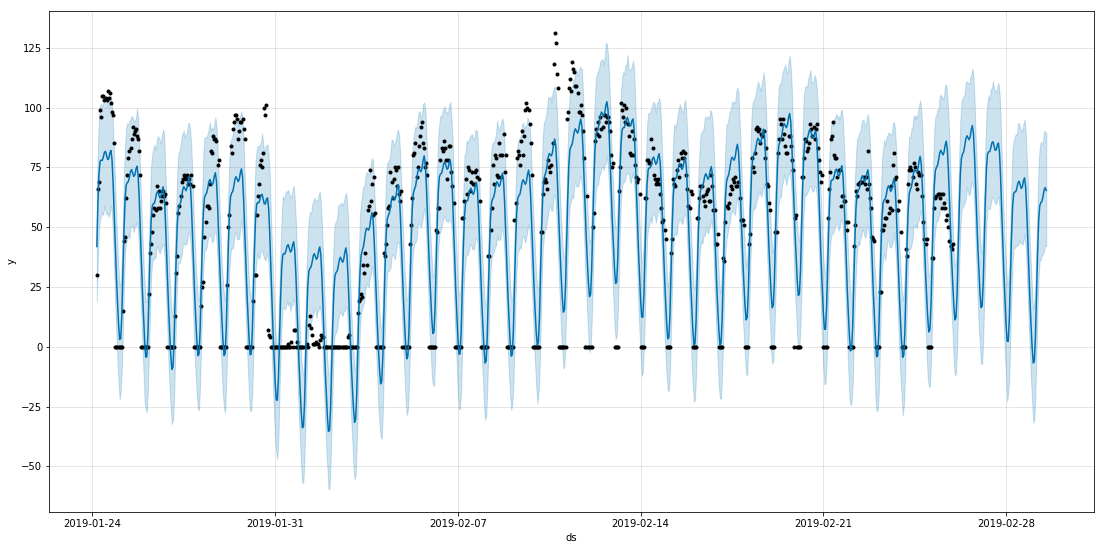

In [35]:
fig1 = m.plot(forecast)
fig1.set_size_inches(16,8)

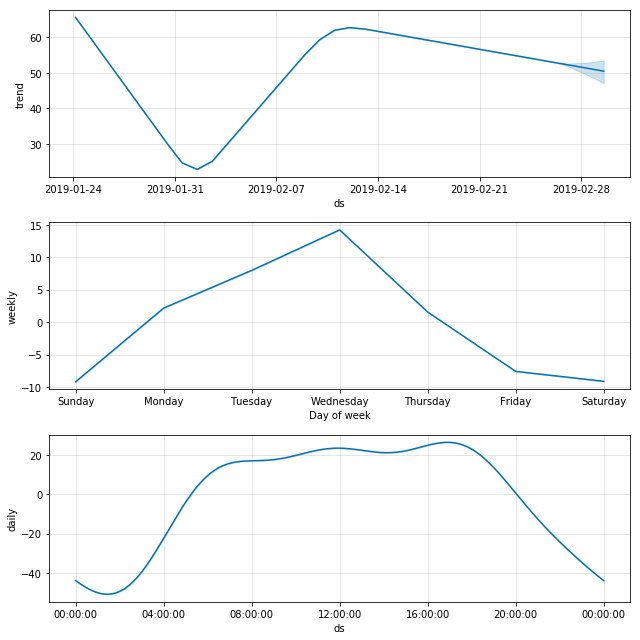

In [36]:
fig2 = m.plot_components(forecast)